In [1]:
# Regular EDA(exploratory data analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
%matplotlib inline

from tqdm import tqdm
import string
import statistics
import re
import joblib
import random
import statistics
from collections import Counter
from scipy import stats
import os
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import cosine_similarity
import zipfile
from matplotlib.lines import Line2D
from sklearn.datasets import make_circles


# PyTorch
import torch
from torch import nn

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [3]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [4]:
circles = pd.DataFrame({
    'X1' : X[:, 0],
    'X2' : X[:, 1],
    'label' : y
})

circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [5]:
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

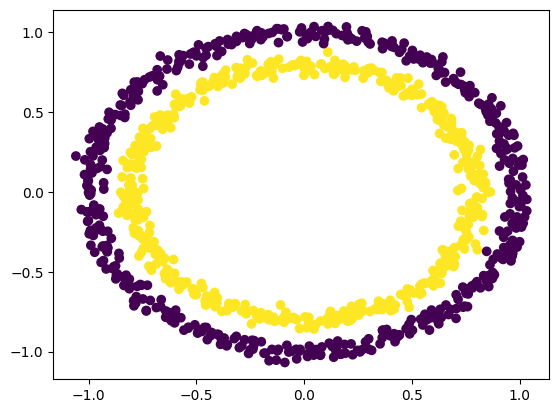

In [6]:
plt.scatter(circles.X1, circles.X2, c = y,  cmap='viridis');

In [7]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [9]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## Building a Model

We've got some data ready, now it's time to build a model.

We'll break it down into a few parts:

1. **Setting up device agnostic code (so our model can run on CPU or GPU if it's available).**
2. **Constructing a model by subclassing `nn.Module`.**
3. **Defining a loss function and optimizer.**
4. **Creating a training loop (this'll be in the next section).**

The good news is we've been through all of the above steps before in notebook 01. Except now we'll be adjusting them so they work with a classification dataset.

Let's start by importing PyTorch and `torch.nn` as well as setting up device agnostic code.


In [11]:
# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [12]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling X and y input and output shapes
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
   
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # Return the output of layer_2, a single feature, the same shape as y
        return self.layer_2(self.layer_1(x))
        
# 4. Create an instance of the model and send it to target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))

print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.4876],
        [-0.2477],
        [-0.8238],
        [-0.3936],
        [-0.3592],
        [-0.2163],
        [ 0.0909],
        [ 0.0995],
        [-0.8429],
        [-0.2265]], device='cuda:0', grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [15]:
# Create a loss function
# loss_fn = nn.BCELoss()   # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                           lr=0.1)

In [16]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [17]:
# torch.eq(torch.Tensor([1,3,3]), torch.Tensor([2,3,3])).sum().item()

In [18]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.4876],
        [-0.2477],
        [-0.8238],
        [-0.3936],
        [-0.3592]], device='cuda:0', grad_fn=<SliceBackward0>)

In [19]:
y_pred_prob = torch.sigmoid(y_logits)
y_pred_prob

tensor([[0.3805],
        [0.4384],
        [0.3050],
        [0.4029],
        [0.4112]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [28]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_prob)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds, y_pred_labels).squeeze())

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [32]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [36]:
torch.manual_seed(42)

# set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in tqdm(range(epochs)):
    ### Training 
    model_0.train()
    
    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backwards
    loss.backward()
    
    # 5. Optimizer step
    optimizer.step()
    
    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward Pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
    
    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

100%|██████████| 100/100 [00:00<00:00, 738.43it/s]

Epoch: 0 | Loss: 0.72076, Accuracy: 43.75% | Test loss: 0.72690, Test acc: 41.00%
Epoch: 10 | Loss: 0.70459, Accuracy: 48.75% | Test loss: 0.71024, Test acc: 48.00%
Epoch: 20 | Loss: 0.69917, Accuracy: 48.00% | Test loss: 0.70375, Test acc: 49.50%
Epoch: 30 | Loss: 0.69703, Accuracy: 49.50% | Test loss: 0.70068, Test acc: 49.00%
Epoch: 40 | Loss: 0.69594, Accuracy: 49.88% | Test loss: 0.69892, Test acc: 50.00%
Epoch: 50 | Loss: 0.69528, Accuracy: 49.75% | Test loss: 0.69776, Test acc: 50.50%
Epoch: 60 | Loss: 0.69481, Accuracy: 49.75% | Test loss: 0.69694, Test acc: 50.50%
Epoch: 70 | Loss: 0.69446, Accuracy: 49.75% | Test loss: 0.69632, Test acc: 50.50%
Epoch: 80 | Loss: 0.69419, Accuracy: 49.50% | Test loss: 0.69586, Test acc: 50.50%
Epoch: 90 | Loss: 0.69397, Accuracy: 49.50% | Test loss: 0.69550, Test acc: 50.50%


In [37]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

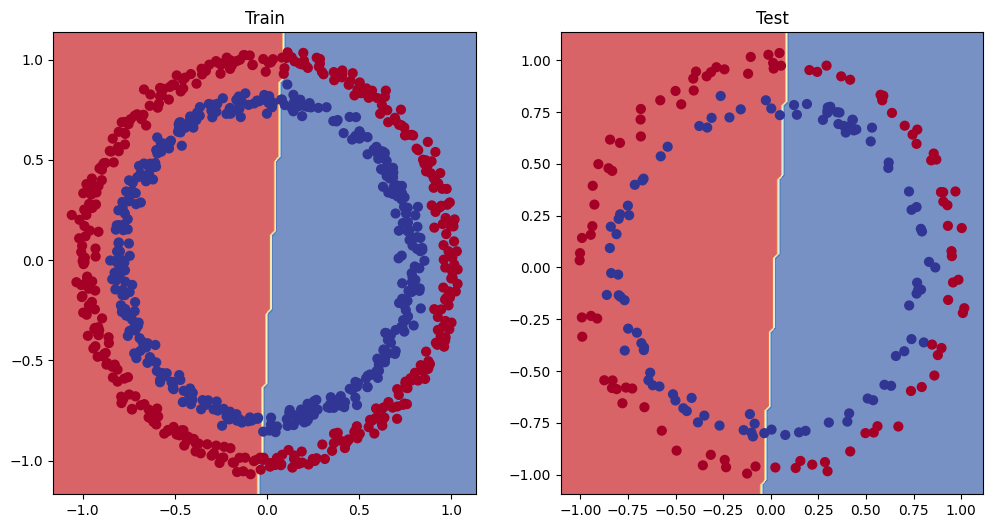

In [38]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [39]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [40]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression), 
    len(y_train_regression), 
    len(X_test_regression), 
    len(y_test_regression))

80 80 20 20


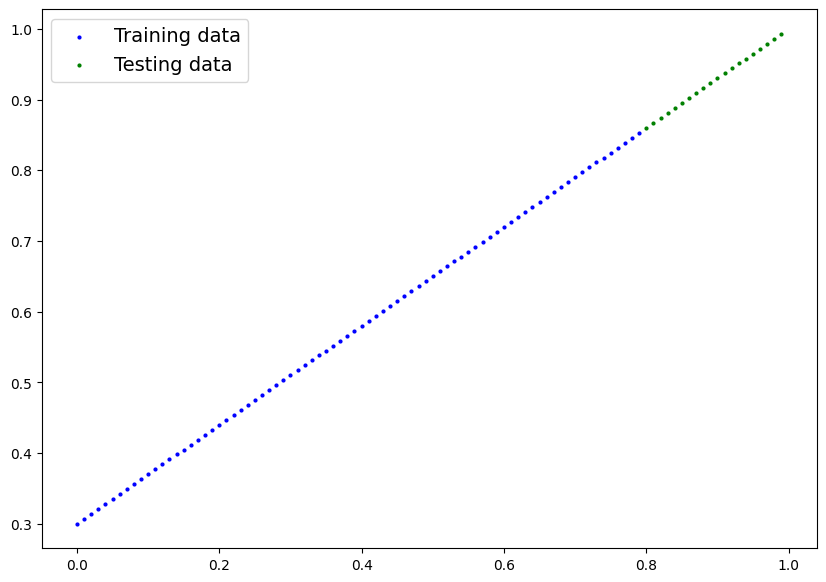

In [41]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

In [42]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [43]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [44]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training 
    # 1. Forward pass
    y_pred = model_2(X_train_regression)
    
    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate the loss 
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0: 
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02901
Epoch: 200 | Train loss: 0.07376, Test loss: 0.02850
Epoch: 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch: 400 | Train loss: 0.06107, Test loss: 0.02004
Epoch: 500 | Train loss: 0.05698, Test loss: 0.01061
Epoch: 600 | Train loss: 0.04857, Test loss: 0.01326
Epoch: 700 | Train loss: 0.06109, Test loss: 0.02127
Epoch: 800 | Train loss: 0.05599, Test loss: 0.01426
Epoch: 900 | Train loss: 0.05571, Test loss: 0.00603


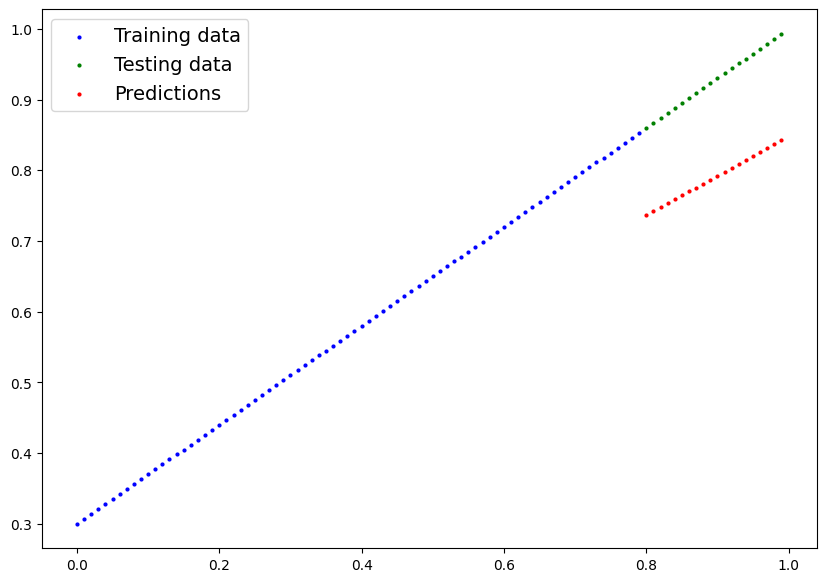

In [45]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

In [47]:
# model_2.state_dict()

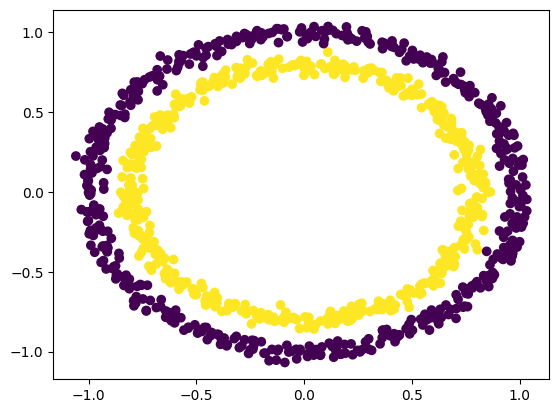

In [54]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis');

In [55]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [56]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [58]:
# setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                           lr = 0.1)

In [59]:
# Fit the model 
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass 
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    
    # 2. Calculate the loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss Backward 
    loss.backward()
    
    # 5.Optimizer Step
    optimizer.step()
    
    ### Testing
    model_3.eval()
    
    with torch.inference_mode():
        # 1. Forward Pass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # 2. Calculate loss and acuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_pred)
        
     # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f}, Train Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Train Loss: 0.69295, Train Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Train Loss: 0.69115, Train Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Train Loss: 0.68977, Train Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Train Loss: 0.68795, Train Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Train Loss: 0.68517, Train Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Train Loss: 0.68102, Train Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Train Loss: 0.67515, Train Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Train Loss: 0.66659, Train Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Train Loss: 0.65160, Train Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Train Loss: 0.62362, Train Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy:

In [63]:
# Make Predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

y_preds[:10], y_test[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

In [68]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

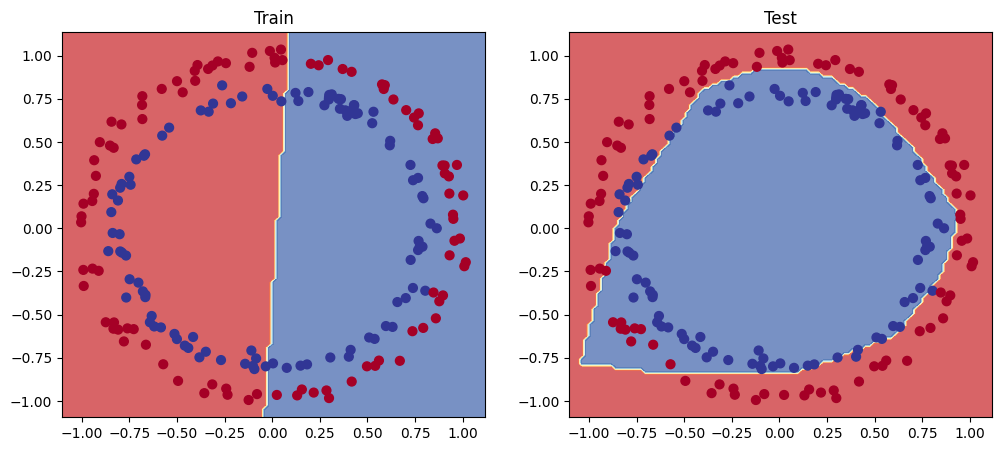

In [70]:
# Plot decision boundaries for training and test set
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model_0, X_test, y_test) # model_0 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity


## 7. Replicating non-linear activation functions

In [71]:
# Create a toy tensor (similar to the data going into our model(s))
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

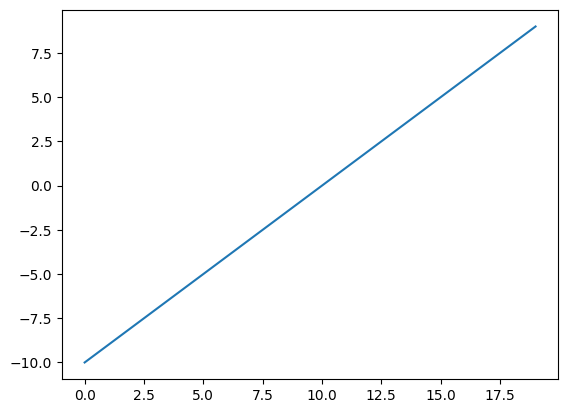

In [73]:
plt.plot(A);

In [74]:
# Create ReLU function by hand 
def relu(x):
    return torch.maximum(torch.tensor(0), x) # inputs must be tensors

# Pass toy tensor through ReLU function
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

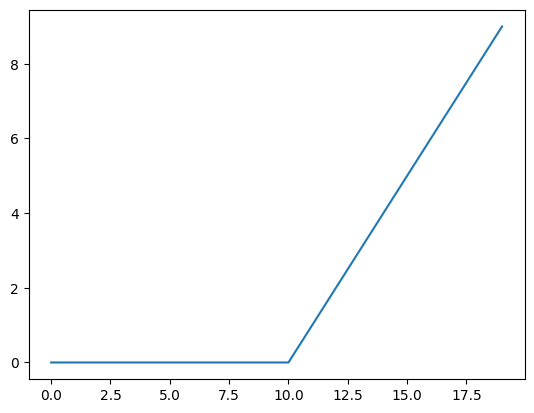

In [75]:
# Plot ReLU activated toy tensor
plt.plot(relu(A));

In [76]:
# Create a custom sigmoid function
def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

# Test custom sigmoid on toy tensor
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

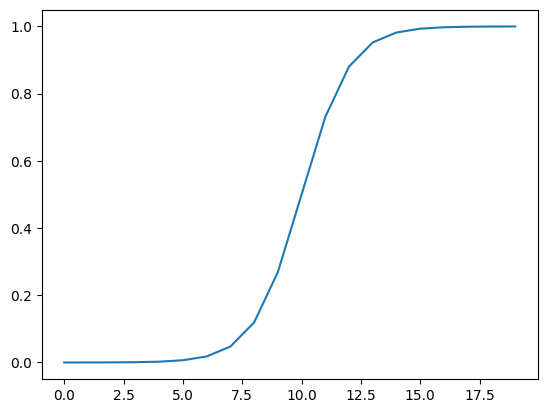

In [77]:
# Plot sigmoid activated toy tensor
plt.plot(sigmoid(A));

## 8.1 Creating Multi-class Classification Data

To begin a multi-class classification problem, let's create some multi-class data.

To do so, we can leverage Scikit-Learn's `make_blobs()` method.

This method will create however many classes (using the `centers` parameter) we want.

Specifically, let's do the following:

1. Create some multi-class data with `make_blobs()`.
2. Turn the data into tensors (the default of `make_blobs()` is to use NumPy arrays).
3. Split the data into training and test sets using `train_test_split()`.
4. Visualize the data.


tensor([[-8.1301,  6.6763],
        [-5.0244, -6.1319],
        [-5.4838, -6.6901],
        [ 3.4915, -0.1514],
        [ 3.9909, -1.7847]]) tensor([3, 2, 2, 1, 1])


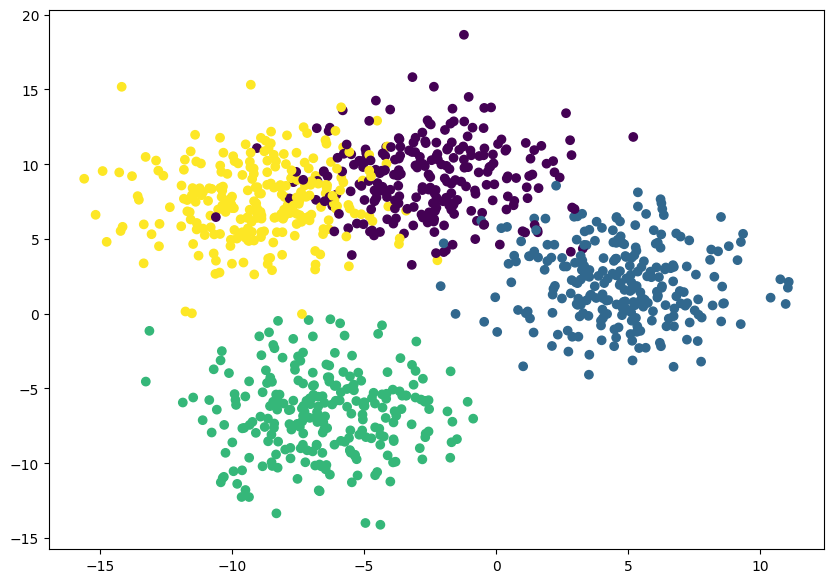

In [147]:
# Import dependencies
from sklearn.datasets import make_blobs

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=2.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap='viridis');

In [148]:
# Build Model

class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = input_features, out_features=hidden_units),
#             nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
#             nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

        
    def forward(self, x):
        return self.linear_layer_stack(x)


# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

## 8.3 Creating a Loss Function and Optimizer for a Multi-class PyTorch Model

Our multi-class model is ready to go; now, let's create a loss function and optimizer for it.

### Loss Function:

Since we're working on a multi-class classification problem, we'll use the `nn.CrossEntropyLoss()` method as our loss function. This loss function is commonly used for multi-class classification tasks in PyTorch.



In [149]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.001)

In [150]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[-1.3942, -0.7673, -1.6267, -0.7132],
        [ 0.2181, -1.5904,  0.0321,  1.1859],
        [ 3.2329,  1.1002,  3.7440,  1.5507],
        [ 1.7126,  0.0973,  1.9232,  1.1001],
        [ 0.7594, -1.0808,  0.7023,  1.2313]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [151]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))
# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.3672, -1.0370, -1.6359, -0.4886],
        [ 1.5973, -1.1831,  1.6114,  1.9732],
        [ 2.1832,  0.8621,  2.5524,  0.8973],
        [-0.6078, -0.3055, -0.6931, -0.4372],
        [-0.8722, -1.7035, -1.1864,  0.4061]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1798, 0.2501, 0.1374, 0.4327],
        [0.2831, 0.0176, 0.2871, 0.4122],
        [0.3345, 0.0893, 0.4838, 0.0924],
        [0.2244, 0.3035, 0.2060, 0.2661],
        [0.1737, 0.0757, 0.1269, 0.6237]], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [152]:
# Which class does the model think is *most* likely at the index ri sample?
ri = 2
print(y_pred_probs[ri])
print(torch.argmax(y_pred_probs[ri]))

tensor([0.3345, 0.0893, 0.4838, 0.0924], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(2, device='cuda:0')


In [153]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 1000

# Put data on target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()
    
    # 1. Forward pass
    y_logits = model_4(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_blob_train, y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    
    # 4. Loss backwards
    loss.backward()
    
    #5. Optimizer step
    optimizer.step()
    
    ### Testing
    model_4.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
        # 2. Calculate test loss and accuracy
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)
    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.06309, Acc: 61.38% | Test Loss: 1.04030, Test Acc: 62.00%
Epoch: 100 | Loss: 0.68255, Acc: 78.62% | Test Loss: 0.67424, Test Acc: 81.50%
Epoch: 200 | Loss: 0.53297, Acc: 90.00% | Test Loss: 0.52737, Test Acc: 94.00%
Epoch: 300 | Loss: 0.45003, Acc: 91.38% | Test Loss: 0.44409, Test Acc: 94.00%
Epoch: 400 | Loss: 0.39671, Acc: 91.75% | Test Loss: 0.38971, Test Acc: 94.50%
Epoch: 500 | Loss: 0.35943, Acc: 91.75% | Test Loss: 0.35119, Test Acc: 94.50%
Epoch: 600 | Loss: 0.33192, Acc: 91.88% | Test Loss: 0.32243, Test Acc: 93.50%
Epoch: 700 | Loss: 0.31086, Acc: 91.88% | Test Loss: 0.30015, Test Acc: 94.00%
Epoch: 800 | Loss: 0.29428, Acc: 91.88% | Test Loss: 0.28245, Test Acc: 94.00%
Epoch: 900 | Loss: 0.28095, Acc: 91.88% | Test Loss: 0.26808, Test Acc: 94.00%


In [154]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_preds = torch.softmax(model_4(X_blob_test), dim=1).argmax(dim=1)
y_preds[:5], y_blob_test[:5]

(tensor([1, 3, 2, 1, 0], device='cuda:0'),
 tensor([1, 3, 2, 1, 0], device='cuda:0'))

In [155]:

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 94.0%


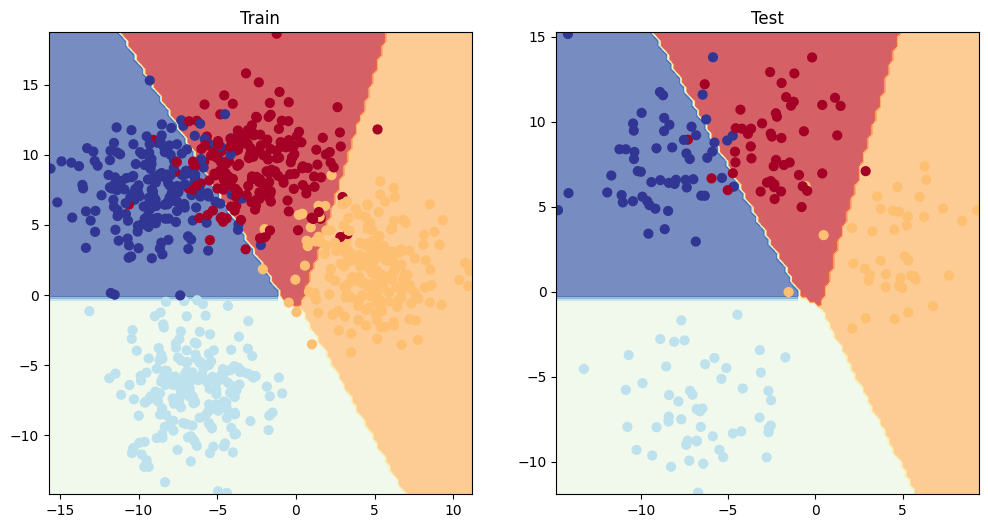

In [156]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [157]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9400, device='cuda:0')